In [1]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
cdc_diabetes_health_indicators = fetch_ucirepo(id=891) 
  
# data (as pandas dataframes) 
X = cdc_diabetes_health_indicators.data.features 
y = cdc_diabetes_health_indicators.data.targets 

In [2]:
X.shape, y.shape

((253680, 21), (253680, 1))

In [3]:
y['Diabetes_binary'].value_counts()

Diabetes_binary
0    218334
1     35346
Name: count, dtype: int64

In [4]:
35346 / (35346+218334)

0.13933301797540207

In [5]:
# do eda 
# no rebalancing 
# build a pipeline model (consider models that are robust to imbalanced datasets)

In [6]:
X.select_dtypes(include=['number']).columns, X.select_dtypes(include=['object']).columns

(Index(['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke',
        'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
        'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
        'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
        'Income'],
       dtype='object'),
 Index([], dtype='object'))

In [7]:
[x for x in X.columns.tolist() if X[x].nunique() < 8]

['HighBP',
 'HighChol',
 'CholCheck',
 'Smoker',
 'Stroke',
 'HeartDiseaseorAttack',
 'PhysActivity',
 'Fruits',
 'Veggies',
 'HvyAlcoholConsump',
 'AnyHealthcare',
 'NoDocbcCost',
 'GenHlth',
 'DiffWalk',
 'Sex',
 'Education']

In [8]:
X['PhysActivity'].unique()

array([0, 1])

In [9]:
cat_cols = [x for x in X.columns.tolist() if X[x].nunique() < 9]
num_cols = [x for x in X.columns.tolist() if X[x].nunique() >= 9]

In [10]:
cat_cols, num_cols

(['HighBP',
  'HighChol',
  'CholCheck',
  'Smoker',
  'Stroke',
  'HeartDiseaseorAttack',
  'PhysActivity',
  'Fruits',
  'Veggies',
  'HvyAlcoholConsump',
  'AnyHealthcare',
  'NoDocbcCost',
  'GenHlth',
  'DiffWalk',
  'Sex',
  'Education',
  'Income'],
 ['BMI', 'MentHlth', 'PhysHlth', 'Age'])

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
data = pd.concat([X, y], axis=1)
target_variable = 'Diabetes_binary'

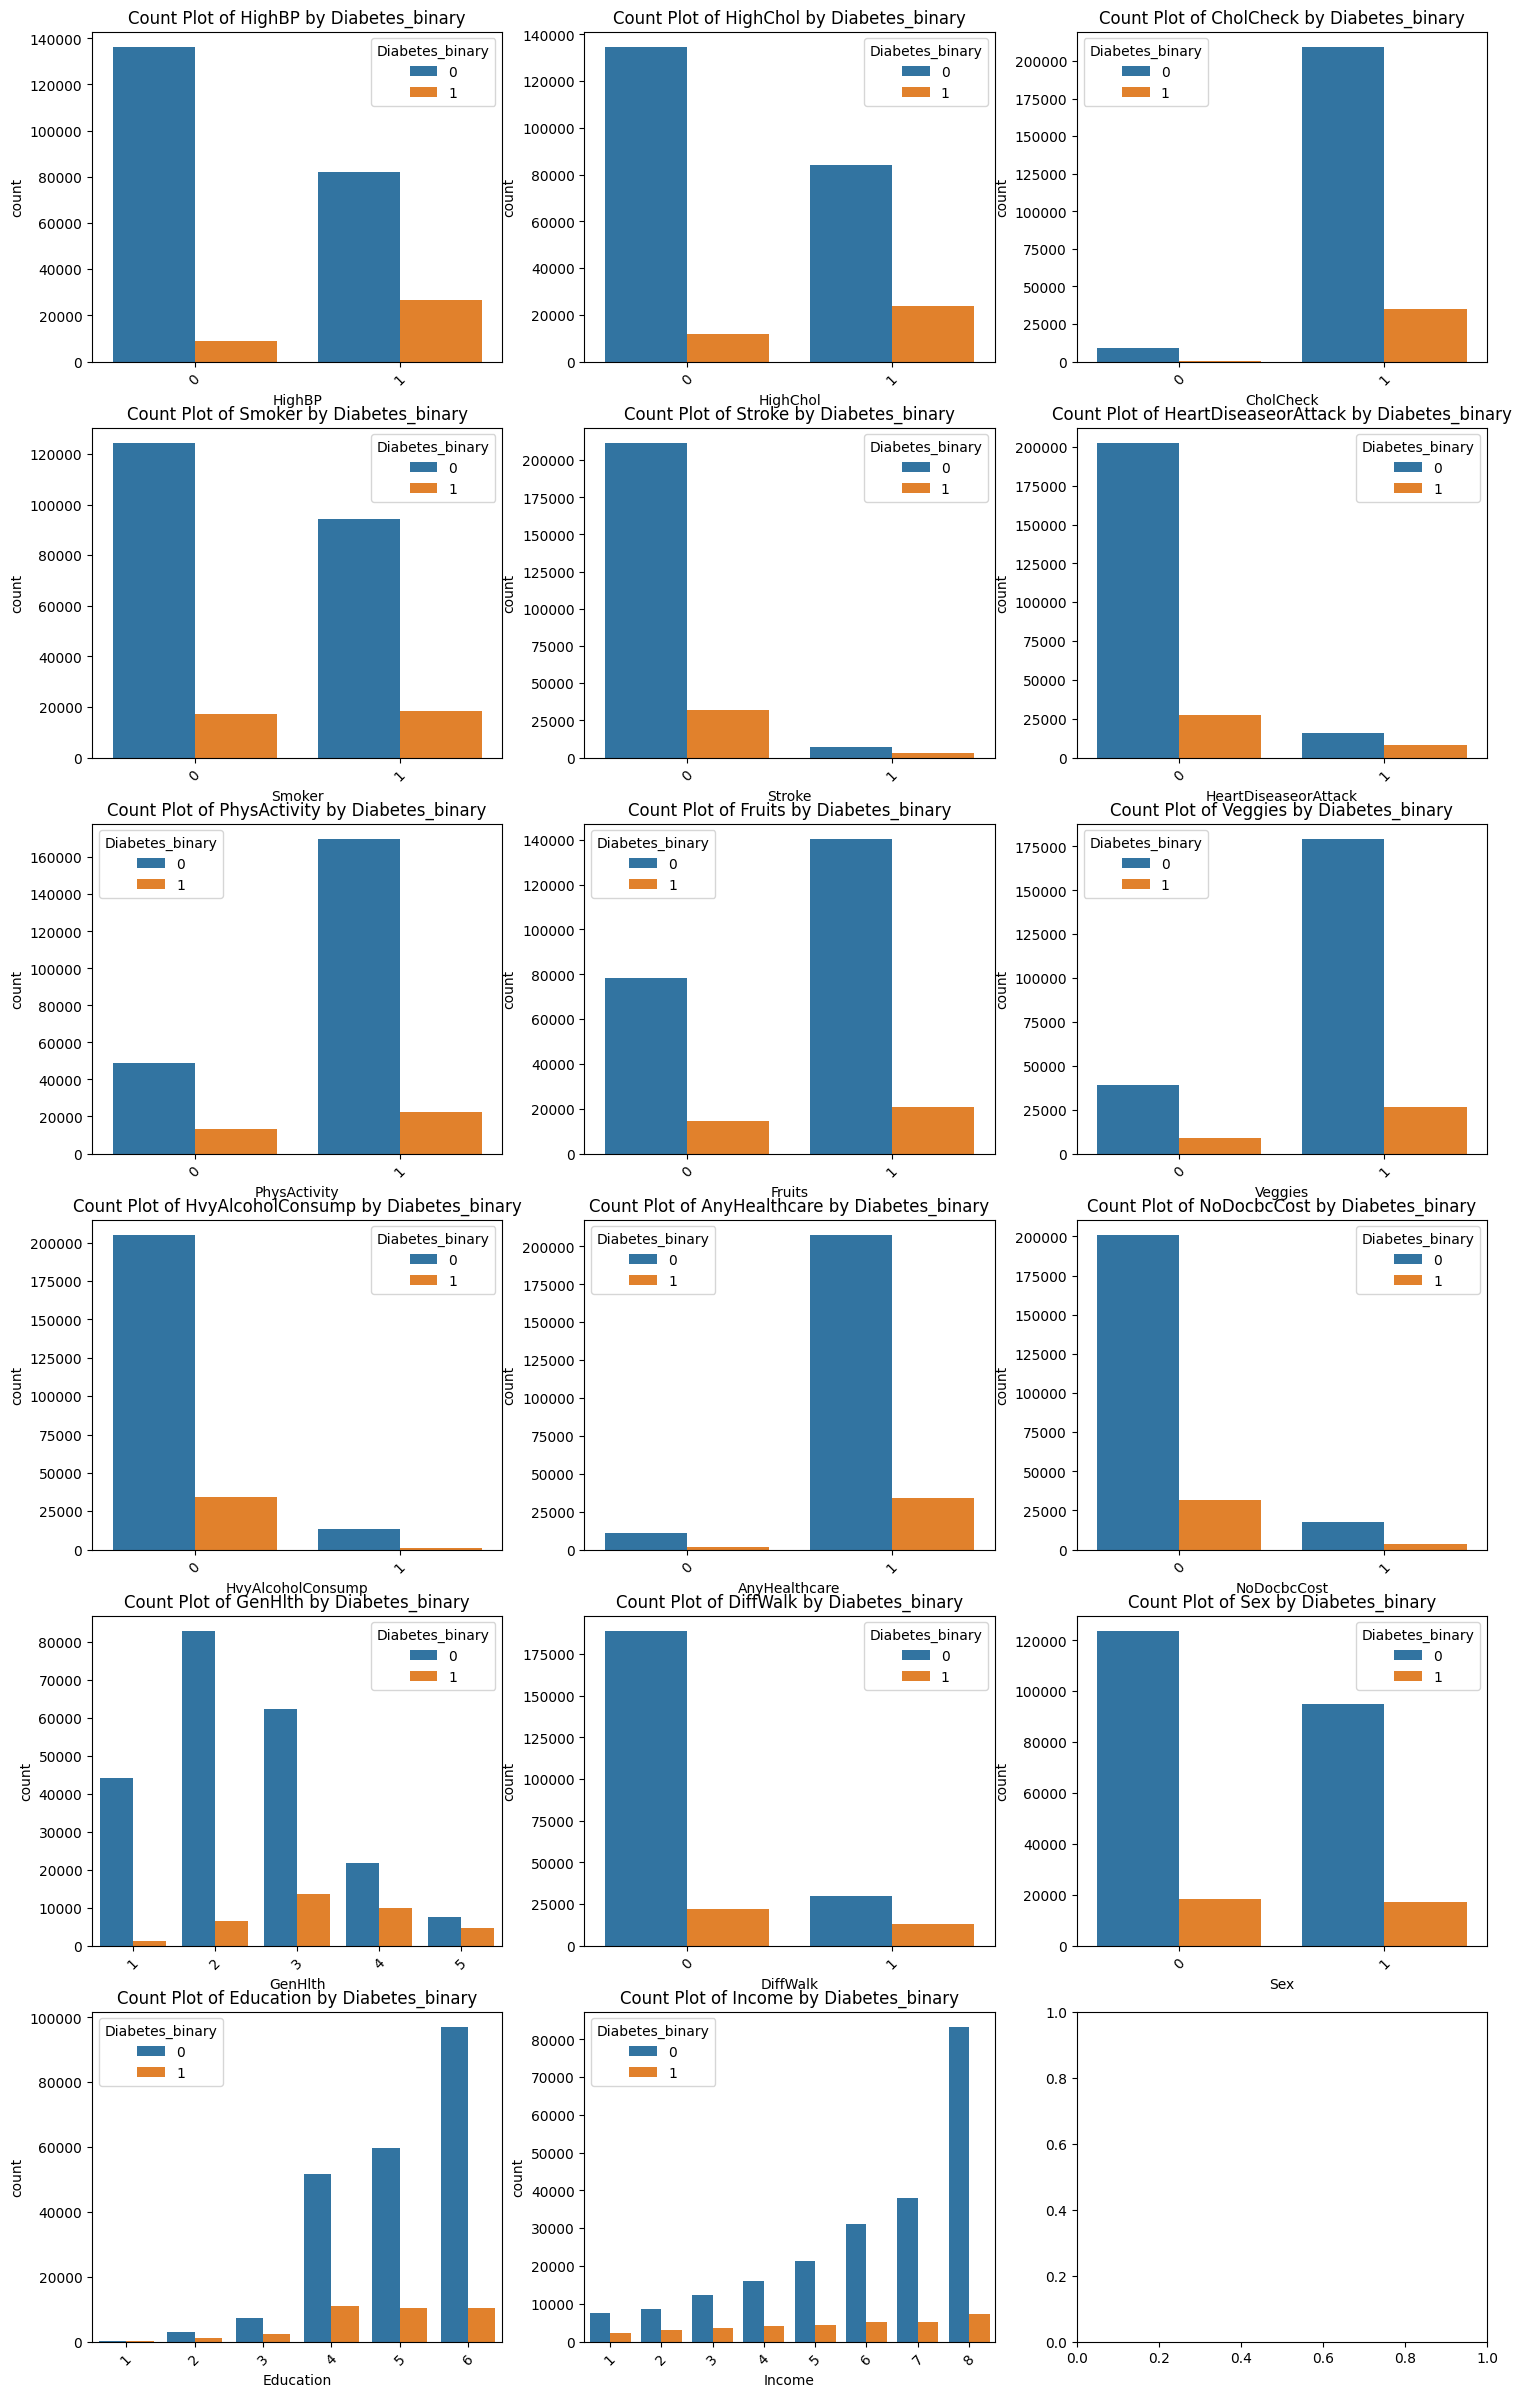

In [13]:
n_cols = 3
n_rows = len(cat_cols) // n_cols + (len(cat_cols) % n_cols > 0)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    sns.countplot(x=col, hue=target_variable, data=data, ax=axes[i])
    axes[i].set_title(f"Count Plot of {col} by {target_variable}")
    axes[i].tick_params(axis='x', rotation=45)

In [14]:
data['MentHlth'].nunique()

31

In [15]:
## Chi-Square Test of Independence

## Whether there is a statistically significant association 
##    between the categorical variable and the target variable

## when p is significant, chi2 determines the strength of the relationship

from scipy.stats import chi2_contingency

chi2_p = {}

for col in cat_cols:
    contingency_table = pd.crosstab(data[col], 
                                    data[target_variable])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    chi2_p[col] = p

chi2_p

{'HighBP': 0.0,
 'HighChol': 0.0,
 'CholCheck': 3.7513988789188705e-233,
 'Smoker': 8.640171809942516e-206,
 'Stroke': 0.0,
 'HeartDiseaseorAttack': 0.0,
 'PhysActivity': 0.0,
 'Fruits': 1.0881213885155634e-93,
 'Veggies': 1.4630291539062376e-178,
 'HvyAlcoholConsump': 1.8659318101056406e-181,
 'AnyHealthcare': 2.986181073970452e-16,
 'NoDocbcCost': 2.218395410122378e-56,
 'GenHlth': 0.0,
 'DiffWalk': 0.0,
 'Sex': 2.1098747365768505e-56,
 'Education': 0.0,
 'Income': 0.0}

<Axes: >

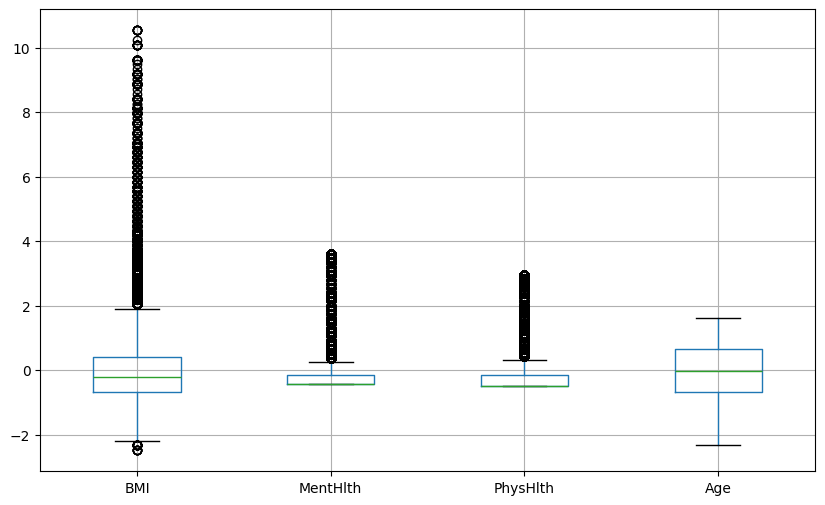

In [16]:
## Numeric columns

num = (X[num_cols] - X[num_cols].mean())/X[num_cols].std()
num.boxplot(figsize=(10, 6))

In [17]:
## Outliers Percentage
outliers = {}

for col in num_cols:

    Q1 = X[col].quantile(0.25)
    Q3 = X[col].quantile(0.75)

    IQR = Q3 - Q1

    lower_bound = Q1 - (1.5 * IQR)
    upper_bound = Q3 + (1.5 * IQR)

    outliers[col] = (len(X[(X[col] < lower_bound) | (X[col] > upper_bound)]) * 100)/ len(X)

outliers

{'BMI': 3.881661936297698,
 'MentHlth': 14.273099968464207,
 'PhysHlth': 16.1419899085462,
 'Age': 0.0}

In [18]:
import warnings
warnings.filterwarnings("ignore")

In [19]:
# Splitting the dataset

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.metrics import recall_score

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y.values.reshape(-1), test_size=0.3)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)

X_train.shape, y_train.shape, X_val.shape, X_test.shape

((159818, 21), (159818,), (17758, 21), (76104, 21))

In [21]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('ohe', ohe, cat_cols)
    ]
)

In [22]:
## Models and Parameters
models = [RandomForestClassifier(), XGBClassifier(verbosity = 0, use_label_encoder=False)]
model_p = [
    {
        'classifier__n_estimators': [10, 15, 20, 50, 75, 100, 150],
        'classifier__max_depth': [15, 20, 25, 30, 35, 40, 45, 50]
    },
    {
        'classifier__n_estimators': [10, 15, 20, 50, 75, 100, 150],
        'classifier__max_depth': [15, 20, 25, 30, 35, 40, 45, 50]
    }
]

In [23]:
X_train.shape, y_train.shape

((159818, 21), (159818,))

In [24]:
best_pipeline = None
best_recall = 0.0

In [25]:
for model, params in zip(models, model_p):
    
    pipeline = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ('classifier', model)
        ]
    )

    grid = GridSearchCV(estimator=pipeline, 
                        param_grid=params, 
                        cv=5, 
                        scoring='recall', 
                        n_jobs=-1)
    grid.fit(X_train, y_train)

    print(f"Best Pipeline : {grid.best_estimator_}")
    print(f"Train Score: {grid.best_score_}")

    val_score = recall_score(y_val, grid.best_estimator_.predict(X_val))
    print(f"Test Score: {val_score}")
    
    if val_score > best_recall:
        best_recall = val_score
        best_pipeline = grid.best_estimator_

print("=================================================")
print("Done!")
print(best_pipeline)

Best Pipeline : Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['HighBP', 'HighChol',
                                                   'CholCheck', 'Smoker',
                                                   'Stroke',
                                                   'HeartDiseaseorAttack',
                                                   'PhysActivity', 'Fruits',
                                                   'Veggies',
                                                   'HvyAlcoholConsump',
                                                   'AnyHealthcare',
                                                   'NoDocbcCost', 'GenHlth',
                                                   'DiffWalk', 'Sex',
          

In [ ]:
recall_score(y_test, best_pipeline.predict(X_test))